In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools as axtools

import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import itertools
import tempfile
import six
import networkx as nx
import scipy.stats as stats
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime

from scipy.stats import mode
dy_name = 'gs_qc_analysis'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)
import gzip

In [3]:
def prep_info_color_plot(info):
    # assign colors to different 
    info['color_plot'] = '#00a563'

    batch_hwe = info[(info.filter_hwe == True) & (info.filter_batch == True)].index.tolist()
    batch_only = info[(info.filter_hwe == False) & (info.filter_batch == True)].index.tolist()
    hwe_only = info[(info.filter_hwe == True) & (info.filter_batch == False)].index.tolist()

    info.loc[batch_hwe, 'color_plot'] = '#b73550'
    info.loc[batch_only, 'color_plot'] = '#7c00ff'
    info.loc[hwe_only, 'color_plot'] = '#4286f4'
    return info


In [155]:
def get_pnmode_ipscore_hipsci(info_v3, samples_ipscore, samples_hipsci_fib):
    data = []
    s_ipscore = set(samples_ipscore)
    s_hipsci  = set(samples_hipsci_fib)
    for i,x in info_v3.iterrows():
        chrom = x['Chr']
        
        lq_ipscore = x['lq_samps_ipscore_fb']
        lq_hipsci = x['lq_samps_hipsci_fib']
        
        num_lq_ipscore = len(lq_ipscore)
        num_lq_hipsci = len(lq_hipsci)
        
        nmode_samps = x['diff_mode_uuids']
        
        nmode_ipscore = len(s_ipscore.intersection(nmode_samps))
        nmode_hipsci = len(s_hipsci.intersection(nmode_samps))
        
        num_passing_ipscore = 274 - num_lq_ipscore
        num_passing_hipsci = 204 - num_lq_hipsci
        
        if num_passing_ipscore > 0:
            pnmode_ipscore = nmode_ipscore/num_passing_ipscore
        else:
            pnmode_ipscore = 0
        
        if num_passing_hipsci > 0:
            pnmode_hipsci = nmode_hipsci/num_passing_hipsci
        else:
            pnmode_hipsci = 0
        
        
        
        data.append([i, chrom, num_passing_ipscore, num_passing_hipsci, num_lq_ipscore, num_lq_hipsci, 
                     pnmode_ipscore, pnmode_hipsci, nmode_ipscore, nmode_hipsci])
        
    df = pd.DataFrame(data, columns=['ID', 'Chr','num_pass_ipscore', 'num_pass_hipsci', 
                                     'num_lq_ipscore', 'num_lq_hipsci',
                                    'pnmode_ipscore', 'pnmode_hipsci', 'nmode_ipscore', 'nmode_hipsci'])
    df.index = df.ID
    df = df.join(info_v3[['filter_batch', 'filter_hwe']])
    
    return df
    
    

In [16]:
def prep_filter_info_plot(df):
    # lets only look at the autosomes
    df = df[~df.Chr.isin(['X', 'Y'])].copy()
    return df 

In [4]:
sample_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/sample_info_combined/sample_info.pkl')

# subsets we will need for unifying genotype fields

samples_ipscore = sample_info[(sample_info.STUDY != 'HipSci')].WGS_ID.tolist()


samples_ipscore_unrel = sample_info[(sample_info.STUDY != 'HipSci') & (sample_info.In_Unrelated_Set == True)].WGS_ID.tolist()


samples_hipsci_fib = sample_info[(sample_info.STUDY == 'HipSci') & (sample_info.CELL_TYPE == 'Fibroblast')].WGS_ID.tolist()

In [9]:
gs_qc_stats_stitch_annot_qual_sc_batch_hwe = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/gs_qc_stats_stitch_annot_qual_sc_batch_hwe.pkl')

In [120]:
gs_info = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_processing_V4/i2QTL_combined/gs_info_stitch_annot_qual_sc_batch_hwe.pkl')

In [122]:
colors_reversed = list(reversed(['#4286f4', '#7c00ff', '#b73550', '#00a563']))

In [156]:
pnmode_df = get_pnmode_ipscore_hipsci(gs_info, samples_ipscore, samples_hipsci_fib).pipe(prep_info_color_plot).pipe(prep_filter_info_plot)

In [157]:
mpl.rcParams['xtick.major.pad'] = 2
mpl.rcParams['ytick.major.pad'] = 1.5

mpl.rcParams['axes.labelpad'] = 2

mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14

categories = ['HWE', 'Batch', 'HWE,Batch', 'PASS']
colors = ['#4286f4', '#7c00ff', '#b73550', '#00a563']

patches = axtools.get_legend_patches(categories, markerfacecolor=colors, markersize= 12)

In [161]:
# for supplemental fig
CM.save_dataframe('gs_batch_hwe_plot', pnmode_df, private_out)

gs_batch_hwe_plot = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis/gs_batch_hwe_plot.pkl')
gs_batch_hwe_plot = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis/gs_batch_hwe_plot.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/gs_qc_analysis/load_pickled_nb_variables.py


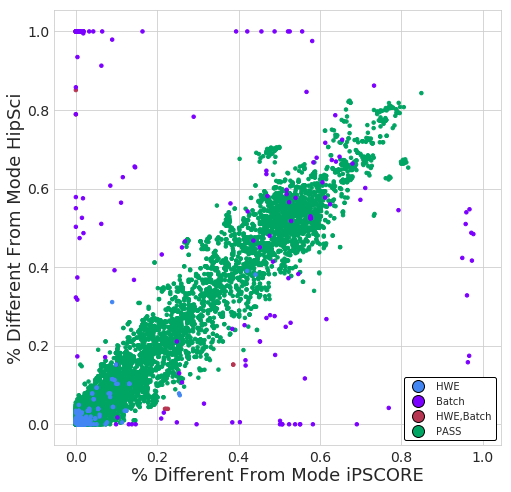

In [158]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(1,1, figsize = (8,8))
    
    
    for i in colors_reversed:
        df = pnmode_df[pnmode_df.color_plot == i]
    
        ax.scatter(df.pnmode_ipscore, df.pnmode_hipsci, c = df.color_plot, s= 12, alpha = 1)
    
    
    ax.set_xlabel('% Different From Mode iPSCORE')
    ax.set_ylabel('% Different From Mode HipSci')
    leg = ax.legend(handles = patches, bbox_to_anchor = (1,0), loc='lower right', frameon=True, framealpha=1, fontsize=10)
    leg.get_frame().set_facecolor('white')
    leg.get_frame().set_edgecolor('black')